In [13]:
import numpy
import torch
import torch.nn as nn
import numpy as np
import random
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn import decomposition

In [14]:
class CTRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dt=None):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        nn.init.orthogonal_(self.h2h.weight)
        self.h2out = nn.Linear(hidden_size, output_size)
        self.initial_hidden = None

    def init_hidden(self, input_shape):
        # batch_size = input_shape[1]
        # init = torch.zeros(batch_size, self.hidden_size)
        init = torch.zeros(self.hidden_size)
        self.initial_hidden = init
        return init

    def recurrence(self, input, hidden):
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape)

        # Loop through time
        hidden_all = []
        steps = range(input.size(0))
        for s in steps:
            hidden = self.recurrence(input[s], hidden)
            hidden_all.append(hidden)

        # Stack together output from all time steps
        hidden_all = torch.stack(hidden_all, dim=0)  # (seq_len, batch, hidden_size)
        output = self.h2out(hidden_all)

        return output, hidden_all

In [15]:
# create a trial

# trial params
stim_start = 1
stim_duration = 0.5 # seconds
delay_duration = 1.5 # seconds
choice_start = stim_start + stim_duration + delay_duration
choice_duration = 1 # seconds
post_duration = 1 # seconds

duration = stim_start + stim_duration + delay_duration + choice_duration + post_duration
dt = 0.5 # seconds

step_lims = torch.arange(0, duration + dt, dt)
n_steps = int(duration / dt)

class Trial():
    def __init__(self, stimulus):
        self.target_val = stimulus
        self.stimulus = torch.zeros((n_steps,2))
        self.stimulus[torch.where(torch.logical_and(step_lims>=stim_start, step_lims<stim_start+stim_duration)),stimulus] = 1
        self.target = torch.zeros((n_steps,2))
        self.target[np.where(np.logical_and(step_lims>=choice_start, step_lims<choice_start+choice_duration)),self.target_val] = 1

t0 = Trial(stimulus=0)

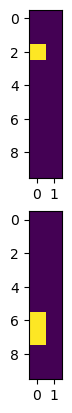

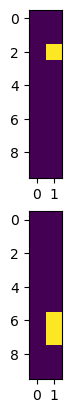

In [4]:
# graphically represent trial
t0 = Trial(stimulus=0)
t1 = Trial(stimulus=1)


fig, axs = plt.subplots(2, 1, sharey=True)
axs[0].imshow(t0.stimulus)
axs[1].imshow(t0.target)


fig, axs = plt.subplots(2, 1, sharey=True)
axs[0].imshow(t1.stimulus)
axs[1].imshow(t1.target)


In [16]:
net = CTRNN(2, 50, 2)

criterion = nn.MSELoss()
learningrate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learningrate)
optimizer.zero_grad()

losstrack = []

# get output for each stim for naiive network

out_og_t0, _ = net(t0.stimulus)
out_og_t1, _ = net(t1.stimulus)

# create a whole bunch of trials
for i in range(1000):
    r = random.choice([0,1])
    t = Trial(stimulus=r)
    out, _ = net(t.stimulus)
    target = t.target
    loss = criterion(out, target)
    losstrack.append(loss.item())
    loss.backward()
    optimizer.step()



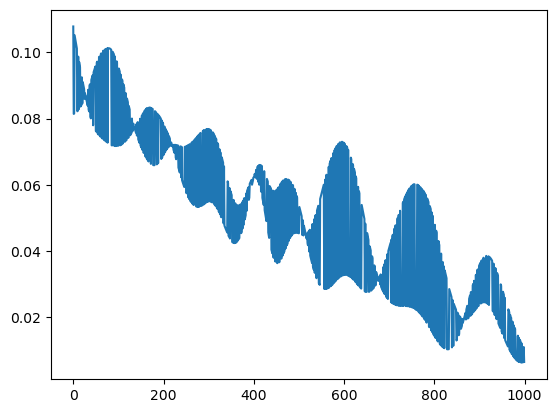

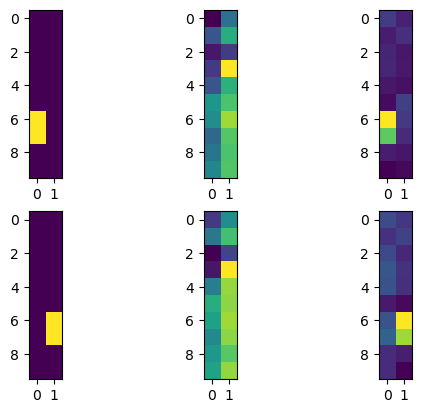

In [17]:
plt.plot(losstrack)

out_t0, _ = net(t0.stimulus)
out_t1, _ = net(t1.stimulus)

fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(t0.target)
axs[0,1].imshow(out_og_t0.detach().numpy())
axs[0,2].imshow(out_t0.detach().numpy())

axs[1,0].imshow(t1.target)
axs[1,1].imshow(out_og_t1.detach().numpy())
axs[1,2].imshow(out_t1.detach().numpy())